**Imports**

In [ ]:
!pip install pyccel
!pip install numba
import numpy as np
import scipy as sp
from scipy import special as ss
import scipy.linalg as lg
import matplotlib.pyplot as pl

import time
from time import process_time


from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types,pure

***transformation functions***

In [2]:

def JT(x):
  return sp.array([[1,2],[-1,0]])                          #Jacobien de FT
  
  
  
def F(x):
  return sp.array([x[0],(1-x[0])*x[1]])                    #Transformation de Duffy

**Pure python function**

In [3]:

def quadrature_pure(d,iteration,B0,B1,w0,w1,malphaBihaApp,grs):
  iteration=0
  q=d+1
  for alpha1 in range(0,d+1):
    for bita1 in range(0,d+1):
      for alpha2 in range(0,d-alpha1+1):
        for bita2 in range(0,d-bita1+1):
          cMalphaBihaApp=0.
          for s in range(0,q):
            for r in range(0,q):
              cMalphaBihaApp=cMalphaBihaApp+(grs*w1[r]*B1[r,alpha1]*B1[r,bita1]*w0[s]*B0[s,d-alpha1,alpha2]*B0[s,d-bita1,bita2] )
          malphaBihaApp[iteration]=((0.5)**3)*cMalphaBihaApp 
          iteration=iteration+1      
    

  return 0

**Numba accelerator**

In [4]:

@njit
def quadrature_numba(d,iteration,B0,w0,B1,w1,malphaBihaApp,grs):
  iteration=0
  q=d+1
  for alpha1 in range(0,d+1):
    for bita1 in range(0,d+1):
      for alpha2 in range(0,d-alpha1+1):
        for bita2 in range(0,d-bita1+1):
          cMalphaBihaApp=0.
          for s in range(0,q):
            for r in range(0,q):
              cMalphaBihaApp=cMalphaBihaApp+(grs*w1[r]*B1[r,alpha1]*B1[r,bita1]*w0[s]*B0[s,d-alpha1,alpha2]*B0[s,d-bita1,bita2] )
          malphaBihaApp[iteration]=((0.5)**3)*cMalphaBihaApp 
          iteration=iteration+1      
    

  return 0

**Pyccel accelerator**

In [5]:
@types('int','int','float[:,:,:]','float[:]','float[:,:]','float[:]','float[:]','float')
def quadrature_pyccel(d,iteration,B0,w0,B1,w1,malphaBihaApp,grs):
  iteration=0
  q=d+1
  for alpha1 in range(0,d+1):
    for bita1 in range(0,d+1):
      for alpha2 in range(0,d-alpha1+1):
        for bita2 in range(0,d-bita1+1):
          cMalphaBihaApp=0.
          for s in range(0,q):
            for r in range(0,q):
              cMalphaBihaApp=cMalphaBihaApp+(grs*w1[r]*B1[r,alpha1]*B1[r,bita1]*w0[s]*B0[s,d-alpha1,alpha2]*B0[s,d-bita1,bita2] )
          malphaBihaApp[iteration]=((0.5)**3)*cMalphaBihaApp 
          iteration=iteration+1      
    

  return 0

In [6]:
quadrature=epyccel(quadrature_pyccel,language='fortran')

**Inputs**

In [ ]:

iteration=0

itars=sp.array([0,0])
zetars=F(itars)
grs=lg.det(JT(zetars))

C0=sp.diag(sp.ones(500))
C0[:,0]=sp.ones(500)
for n in range(1,500):                                   # Formule de pascal
     for m in range(1,n+1):
        C0[n,m]= C0[n-1,m-1]+C0[n-1,m] 


In [22]:
degremax=50

**CALL Functions**

**Function with pyccel accelerator**

In [ ]:
temCPUpyccelQ=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  q=i+1
  t0,w0=ss.roots_jacobi(q,0,0)  
  ita0=(1/2)+0.5*t0  
  t1,w1=ss.roots_jacobi(q,1,0)                   #Méthode de Gauss-Jacobi
  ita1=(1/2)+0.5*t1
  ind=int(C0[i+2,2]**2)
  malphaBihaApp=np.zeros(ind)
  B1=np.ones((q,q))
  B0=np.ones((q,q,q))
  '''
  for s in range(q):
    x=ita0[s]
    y=ita1[s]
    for n in range(q):
      for k in range(n+1):                                           # the calculation with the analytical formula 
        B0[s,n,k]= C0[n,k]*((1-x)**(n-k))*(x**k)
      B1[s,n]=C0[i,n]*((1-y)**(i-n))*(y**n)
      '''
  t1P= process_time()
  quadrature(i,iteration,B0,w0,B1,w1,malphaBihaApp,grs)
  t2P= process_time()
  temCPUpyccelQ.append(t2P-t1P)
  print(i)


**Function with numba accelerator**

In [ ]:
temCPUnumbaQ=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  q=i+1
  t0,w0=ss.roots_jacobi(q,0,0)  
  ita0=(1/2)+0.5*t0  
  t1,w1=ss.roots_jacobi(q,1,0)          #Méthode de Gauss-Jacobi
  ita1=(1/2)+0.5*t1
  ind=int(C0[i+2,2]**2)
  malphaBihaApp=np.zeros(ind)
  B1=np.ones((q,q))
  B0=np.ones((q,q,q))
  t1N= process_time()
  quadrature_numba(i,iteration,B0,w0,B1,w1,malphaBihaApp,grs)
  t2N= process_time()
  temCPUnumbaQ.append(t2N-t1N)
  print(i)

**Pure function**

In [15]:
temCPUpureQ=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  q=i+1
  t0,w0=ss.roots_jacobi(q,0,0)  
  ita0=(1/2)+0.5*t0  
  t1,w1=ss.roots_jacobi(q,1,0)             #Méthode de Gauss-Jacobi
  ita1=(1/2)+0.5*t1
  ind=int(C0[i+2,2]**2)
  malphaBihaApp=np.zeros(ind)
  B1=np.ones((i+1,q))
  B0=np.ones((i+1,q,q))
  t1r= process_time()
  quadrature_pure(i,iteration,B0,B1,w0,w1,malphaBihaApp,grs)
  t2r= process_time()
  temCPUpureQ.append(t2r-t1r)
  print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


*PLOTS*

**Plot pyccel function**

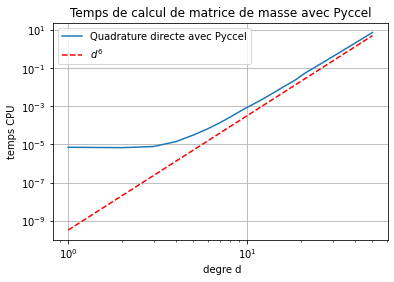

In [27]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUpyccelQ,label='Quadrature directe avec Pyccel')
pl.title("Temps de calcul de matrice de masse avec Pyccel")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=3.2*(10**(-10))
Z=cst*(Degre**6)
pl.plot(degre,Z,'r--',label='$d^6$')
pl.legend()
pl.grid()
pl.show() 

**Plot numba function**

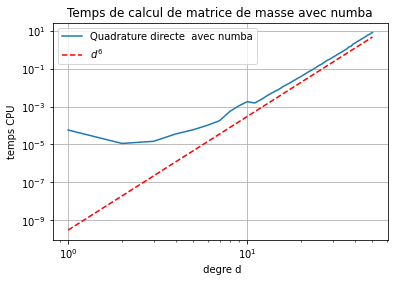

In [30]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUnumbaQ,label='Quadrature directe  avec numba')
pl.title("Temps de calcul de matrice de masse avec numba")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=3*(10**(-10))
Z=cst*(Degre**6)
pl.plot(degre,Z,'r--',label='$d^6$')
pl.legend()
pl.grid()
pl.show() 

**Plot pure function**

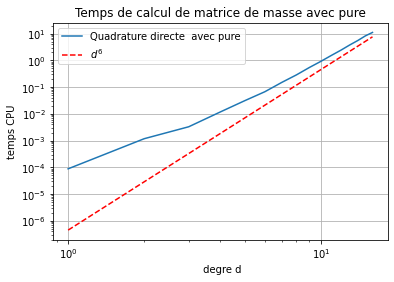

In [20]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUpureQ,label='Quadrature directe  avec pure')
pl.title("Temps de calcul de matrice de masse avec pure")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=4.5*(10**(-7))
Z=cst*(Degre**6)
pl.plot(degre,Z,'r--',label='$d^6$')
pl.legend()
pl.grid()
pl.show() 

*Plots pure, numba and pyccel functions*

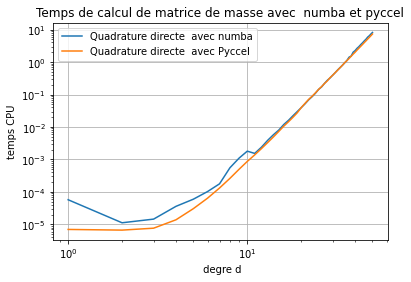

In [32]:
ax = pl.axes(xscale='log', yscale='log')
#pl.plot(degre,temCPUpureQ,label='Quadrature directe  avec pure')
pl.plot(degre,temCPUnumbaQ,label='Quadrature directe  avec numba')
pl.plot(degre,temCPUpyccelQ,label='Quadrature directe  avec Pyccel')
pl.title("Temps de calcul de matrice de masse avec  numba et pyccel")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=4.5*(10**(-10))
Z=cst*(Degre**6)
#pl.plot(degre,Z,'r--',label='$d^6$')
pl.legend()
pl.grid()
pl.show() 